## ToDo:
- Data Agumentation
    - Transformations nebenläufig oder direkt auf das dataset anwenden?
- eigenes CNN vom Aufbau entwickeln
    - ggf. an den Aufbau von der VL halten
    - ggf. Study raussuchen
- CNN Speichern können
    - CNN nutzen um Testdaten zu analysieren und Ergebnis in CSV schreiben
- Accuracy herausfinden
- optimale Learning Rate herausfinden
    - https://towardsdatascience.com/finding-good-learning-rate-and-the-one-cycle-policy-7159fe1db5d6
   

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder


### load and normalize dog dataset

In [8]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
import math

mean = [0.4766, 0.4527, 0.3926]
std = [0.2275, 0.2224, 0.2210]

meanOriginal = [0.5, 0.5, 0.5]
stdOriginal = [0.5, 0.5, 0.5]

#transformer for normalization of images
# transforms.Compose -> pipeline that in this case firstly converts image to tensor and then normalizes it
# - first (0.5, 0.5, 0.5) are the mean for each channel(red, green, blue) and 
# - second is the standard deviation for each channel
# - resize the pictures from 275x183 to 28x28
transform =  transforms.Compose(
    [transforms.Pad(25, padding_mode='symmetric'),
     transforms.RandomHorizontalFlip(), 
     transforms.ToTensor(),
     transforms.Resize((64,64), antialias=False),
     transforms.Normalize(mean, std)])

##### Testset ohne transformations???
transformOriginal =  transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((16,16), antialias=False),
     transforms.Normalize(meanOriginal, stdOriginal)])


#batch, to have a certain amount of example pictures
batch_size = 16


#trainset
train_dir = '/home/ck/Documents/Deep_Learning_Python/convolutional_neural_network/train'
#testset
test_dir = '/home/ck/Documents/Deep_Learning_Python/convolutional_neural_network/test'

#load trainset
train_set = ImageFolder(train_dir,transform = transform)
#load testset
test_set = ImageFolder(test_dir,transform = transformOriginal)


#calculate the size of the training and validation set 
train_size = int(0.8 * len(train_set))  # 80% for training
val_size = len(train_set) - train_size

#Split train_set into training and validation set
train_data, val_data = random_split(train_set,[train_size, val_size], generator=torch.Generator().manual_seed(42))

#Return batch given transformations of the ImageFolder
trainloader = DataLoader(train_data, batch_size=batch_size, shuffle = True, num_workers = 0)
valloader = DataLoader(val_data, batch_size=batch_size, shuffle = True, num_workers = 0)


### Print random image

Label : African_hunting_dog


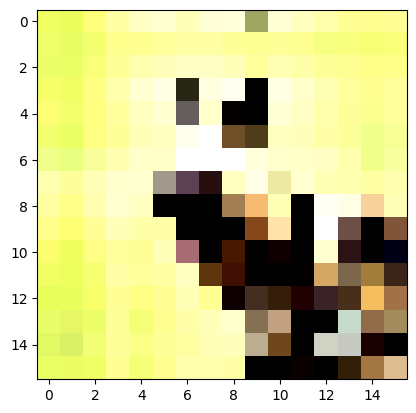

In [9]:
import matplotlib.pyplot as plt
import numpy as np



#Get classes (folder names) of the training set
classes = train_set.classes

#functions to show an image out of the Training set
#print("Follwing classes are there : \n",train_set.classes)
def display_img(img,label):
    print(f"Label : {train_set.classes[label]}")
    img = img / 2 + 0.5 
    img = np.clip(img, 0, 1) # Clip values to the valid range [0, 1]
    plt.imshow(img.permute(1,2,0))

#display the first image [0] in the dataset
display_img(*train_set[0])    # * to unpack the tuple: (img, label)

'\narrY = []\nfor i in range(val_size):\n    X,y = val_data[i]\n    arrY.append(y)\n    \nuArr = np.unique(arrY)\nuArr\n'

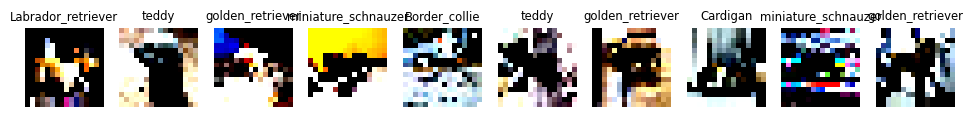

In [6]:
from matplotlib import pyplot as plt
f, axarr = plt.subplots(1,10, figsize=(12, 12))
for i in range(10):
    X,y = train_data[i]
    X = X.transpose(0, -1).transpose(0, 1)
    X = np.clip(X, 0, 1)  # Clip values to the valid range [0, 1]
    y = train_set.classes[y]
    axarr[i].imshow(X)
    axarr[i].axis('off')
    axarr[i].set_title(f'{y}', fontsize='small')

# Hat das val_data images aus allen Klassen?
# -> ja
'''
arrY = []
for i in range(val_size):
    X,y = val_data[i]
    arrY.append(y)
    
uArr = np.unique(arrY)
uArr
'''
#for i, batch in enumerate(valloader):
#    X, y = batch
#    print(i, X.size())


In [10]:
from tqdm import tqdm
import sys
import torch, torch.nn as nn, torch.nn.functional as F

class MyCNNModel(nn.Module):
    def __init__(self, *layers, lr=0.01, classes=None):
        super().__init__() # <- Very important! __init__ from parent class torch.nn 
        self.lr = lr    # learning rate
        self.classes = classes  # classes 
        ## Build model
        self.layers = nn.Sequential(*layers) # Create a sequential model, see below
    
    # Forward pass through the given layers, needed by torch.nn, which is used by train_step
    def forward(self, X):
        return self.layers(X)
    
    # Used after training to predict with the generated model
    def predict(self, X):
        with torch.no_grad():
            y_hat = self(X).argmax(1)
        if self.classes is not None:
            y_hat = [self.classes[i] for i in y_hat]
        return y_hat
    
    # Actual forward pass
    def train_step(self, X, y):
        y_hat = self(X)   # y_hat = prediction, self(X) calls the forward() function above
        # y_hat needs to be the shape (batch_size, classes)
        # y needs to be the shape of batch_size and contain the class of each sample
        # calculates the "cross_entropy"-loss, is prediction == actual image
        return F.cross_entropy(y_hat, y)
        
    def validation_step(self, X, y):
        # temporarily disable gradient, because you don't need it during validation
        with torch.no_grad():
            # calculate the loss, just without the gradient-calculation
            return self.train_step(X, y)
    
    def configure_optimizers(self):
        # self.parameters() = returns an iterator over all the learnable parameters of the model
        # SGD = optimization alg. for nn
        optimizer = torch.optim.SGD(self.parameters(), lr=self.lr)
        return optimizer
        
    def fit(self, train_loader, valid_loader, epochs=10):
        # Load Optimizer
        optimizer = self.configure_optimizers()
        
        # Amount of epochs, one epoch is when all batches are fed into the model to train at once
        for epoch in range(epochs):
            print(f'{epoch+1}/{epochs}:')
            # Training
            self.train() # Set model to training model
            # tqm = loading bar, tepoch == array of all batches
            with tqdm(train_loader, unit="batch", desc='Train: ', colour='#1f77b4',\
                      file=sys.stdout, ncols=80) as tepoch:
                # for each batch in tepoch
                correct = 0
                for X,y in tepoch:
                    optimizer.zero_grad(set_to_none=True) # Sets all gradients to Zero
                    loss = self.train_step(X, y) # Execute Forward pass
                    loss.backward() # Execute Backwval_dataard pass
                    optimizer.step() # Update weights
                    tepoch.set_postfix(loss=f'{loss.item():1.4f}') # Update progress bar
                    
            # Validation
            self.eval() # Set model to validation mode
            with tqdm(train_loader, unit="batch", desc='Valid: ', colour='#ff7f0e',\
                      file=sys.stdout, ncols=80) as tepoch:
               
                for X,y in tepoch:
                    loss_valid = self.validation_step(X, y) # Execute Forward pass without gradients
                    tepoch.set_postfix(loss=f'{loss_valid.item():1.4f}') # Update progress bar
        return self

# Model 1 - First Simple Layered CNN

In [11]:
model1 = MyCNNModel(
    # different functions from torch.nn to modify the model 
    nn.Conv2d(3, 6, (5,5), padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(6, 16, (5,5), padding='same'),
    nn.ReLU(),
    nn.AdaptiveMaxPool2d(1),
    nn.Flatten(1),
    nn.Linear(16, 20), # 20 because 20 classes
    classes=train_set.classes,
).fit(trainloader, valloader, epochs=10)

1/1:
Train:   6%|▎     | 91/1586 [00:08<02:25, 10.31batch/s, accuracy=0, loss=2.5343]


KeyboardInterrupt: 

In [ ]:
torch.save(model1.state_dict(), '/home/ck/Documents/Deep_Learning_Python/convolutional_neural_network/model1.pt')

## Load model1

In [4]:
model1 = MyCNNModel(
    # different functions from torch.nn to modify the model 
    nn.Conv2d(3, 6, (5,5), padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(6, 16, (5,5), padding='same'),
    nn.ReLU(),
    nn.AdaptiveMaxPool2d(1),
    nn.Flatten(1),
    nn.Linear(16, 20), # 20 because 20 classes
    classes=train_set.classes,
)
model1.load_state_dict(torch.load('/home/ck/Documents/Deep_Learning_Python/convolutional_neural_network/model1.pt'))

<All keys matched successfully>

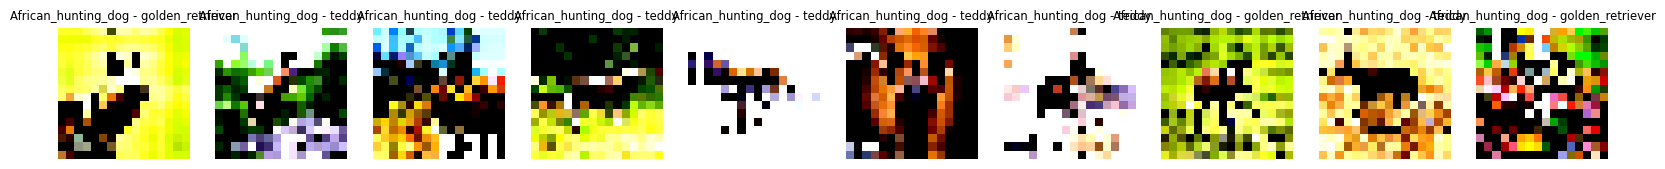

In [7]:
f, axarr = plt.subplots(1,10, figsize=(20, 20))
for i in range(10):
    X,y = train_set[i]
    y_hat = model1.predict(X.unsqueeze(0))[0]
    X = X.transpose(0, -1).transpose(0, 1)
    X = np.clip(X, 0, 1)  # Clip values to the valid range [0, 1]
    y = train_set.classes[y]
    axarr[i].imshow(X)
    axarr[i].axis('off')
    axarr[i].set_title(f'{y} - {y_hat}', fontsize='small')

## Make .csv with predictions

In [52]:
import os
import csv
csv_file = '/home/ck/Documents/Deep_Learning_Python/convolutional_neural_network/prediction.csv'

filenames = []
for image_path, _ in test_set.samples:
    filename = os.path.basename(image_path)
    filenames.append(filename)

predictions = []
for i in range(len(test_set)): 
    X,y = test_set[i]
    y_hat = model1.predict(X.unsqueeze(0))[0]
    predictions.append(y_hat)

    
data = np.column_stack((filenames, predictions))
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    # Write the data to the CSV file
    writer.writerows(data)

print("CSV file written successfully.")


# Accuracy on Validation Dataset
print(AnalyseModel(val_data, model1, train_set.classes).getAccuracy())


CSV file written successfully.
0.25208891691628565


## Calculate Accuracy

In [51]:
class AnalyseModel:
    def __init__(self, val_set, model, classes):
        self.val_set = val_set
        self.model = model
        self.classes = classes
    
    def getAccuracy(self):
        predictions = []
        ys = []
        for i in range(len(self.val_set)): 
            X,y = self.val_set[i]
            y_hat = self.model.predict(X.unsqueeze(0))[0]
            y = self.classes[y]
            predictions.append(y_hat)
            ys.append(y)

        count = 0
        for i in range(len(predictions)):
            if predictions[i] == ys[i]:
                count += 1

        accuracy = count / len(predictions)
        
        return accuracy

# Model 2 - More ReLUs and Convolutions

In [ ]:
model2 = MyCNNModel(
    nn.Conv2d(3, 8, (3,3), padding='same'),
    nn.ReLU(),
    nn.Conv2d(8, 8, (3,3), padding='same'),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(8, 16, (3,3), padding='same'),
    nn.ReLU(),
    nn.Conv2d(16, 16, (3,3), padding='same'),
    nn.ReLU(),
    nn.Conv2d(16, 16, (3,3), padding='same'),
    nn.ReLU(),
    nn.AdaptiveMaxPool2d(1),
    nn.Flatten(1),
    nn.Linear(16, 20),
    classes=testset.classes,
).fit(trainloader, valloader, epochs=10)

In [ ]:
f, axarr = plt.subplots(1,10, figsize=(12, 12))
for i in range(10):
    X,y = testset[i]
    y_hat = model2.predict(X.unsqueeze(0))[0]
    X,y = X.transpose(0,-1).transpose(0,1) * 0.5 + 0.5, testset.classes[y]
    axarr[i].imshow(X)
    axarr[i].axis('off')
    axarr[i].set_title(f'{y} - {y_hat}', fontsize='small')

# ResNet full-preactivation Layer

In [ ]:
# Implementation of the full-preactivation ResNet Layer
class MyResLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel, **kwargs):
        super().__init__()
        if in_channels == out_channels:
            self.proj_out = nn.Identity()
        else:
            self.proj_out = nn.Conv2d(in_channels, out_channels, (1,1), **kwargs)
            
        self.res_block = nn.Sequential(
            nn.BatchNorm2d(in_channels), #BN
            nn.ReLU(), #ReLU
            nn.Conv2d(in_channels, out_channels, kernel, **kwargs), #weight
            nn.BatchNorm2d(out_channels), #BN
            nn.ReLU(), #ReLU
            nn.Conv2d(out_channels, out_channels, kernel, **kwargs), #weight
        )
        
    def forward(self, x):
        x_res = self.res_block(x)
        x = self.proj_out(x)
        return  F.relu(x + x_res) #x + x_res

## Model 3 - ResNet Preactivation Layer

In [ ]:
model3 = MyCNNModel(
    MyResLayer(3, 8, (3,3), padding='same'),
    MyResLayer(8, 8, (3,3), padding='same'),
    nn.MaxPool2d(2, 2),
    MyResLayer(8, 16, (3,3), padding='same'),
    MyResLayer(16, 16, (3,3), padding='same'),
    MyResLayer(16, 16, (3,3), padding='same'),
    nn.AdaptiveMaxPool2d(1),
    nn.Flatten(1),
    nn.Linear(16, 20),
    classes=train_set.classes,
).fit(trainloader, valloader, epochs=10)

# Inception Layer Model

In [ ]:
# Implementation of the Inception module with dimension reductions
class MyInceptionLayer(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super().__init__()
        out_channels = out_channels//4
        self.conv1x = nn.Conv2d(in_channels, out_channels, (1,1), **kwargs)
        # change input dimension
        self.conv3x_afterconv1x = nn.Conv2d(out_channels, out_channels, (3,3), **kwargs)
        self.conv5x_afterconv1x = nn.Conv2d(out_channels, out_channels, (5,5), **kwargs)
        
        self.poolx = nn.Sequential(
            nn.MaxPool2d((3,3), stride=(1,1), padding=1),
            nn.Conv2d(in_channels, out_channels, (1,1), **kwargs)
        )
        # change input dimension
        self.conv1x_afterpoolx = nn.Conv2d(out_channels, out_channels, (1,1), **kwargs)
        
    def forward(self, x):
        x_1 = self.conv1x(x)
        
        # feed the 1x1 conv into the 3x3 conv
        x_1x_3 = self.conv3x_afterconv1x(self.conv1x(x))
        # feed the 1x1 conv into the 5x5 conv
        x_1x_5 = self.conv3x_afterconv1x(self.conv1x(x))
        # feed the 3x3 max pooling into the modified 1x1 conv
        x_px_1 = self.conv1x_afterpoolx(self.poolx(x))
        
        # concatenate the outputs of the convolutional operations
        x = torch.cat([x_1, x_1x_3, x_1x_5, x_px_1], dim=1)
        return F.relu(x)

## Model 4 - Inception Layer

In [ ]:
model4 = MyCNNModel(
    MyInceptionLayer(3, 8, padding='same'),
    MyInceptionLayer(8, 8, padding='same'),
    nn.MaxPool2d(2, 2),
    MyInceptionLayer(8, 16, padding='same'),
    MyInceptionLayer(16, 16, padding='same'),
    MyInceptionLayer(16, 16, padding='same'),
    nn.AdaptiveMaxPool2d(1),
    nn.Flatten(1),
    nn.Linear(16, 20),
    classes=train_set.classes,
).fit(trainloader, valloader, epochs=10)

# Model 5 - Mixing ResNet with Inception

In [ ]:
model5 = MyCNNModel(
    MyResLayer(3, 8, (3,3), padding='same'),
    MyResLayer(8, 8, (3,3), padding='same'),
    nn.MaxPool2d(2, 2),
    MyResLayer(8, 16, (3,3), padding='same'),
    MyResLayer(16, 16, (3,3), padding='same'),
    MyInceptionLayer(16, 16, padding='same'),
    MyInceptionLayer(16, 16, padding='same'),
    nn.AdaptiveMaxPool2d(1),
    nn.Flatten(1),
    nn.Linear(16, 20),
    classes=train_set.classes,
).fit(trainloader, valloader, epochs=10)

## Example run of model 5

In [ ]:
f, axarr = plt.subplots(1,10, figsize=(12, 12))
for i in range(10):
    X,y = train_set[i]
    y_hat = model4.predict(X.unsqueeze(0))[0]
    X,y = X.transpose(0,-1).transpose(0,1) * 0.5 + 0.5, train_set.classes[y]
    axarr[i].imshow(X)
    axarr[i].axis('off')
    axarr[i].set_title(f'{y} - {y_hat}', fontsize='small')

## Safe the Model 5

In [ ]:
torch.save(model5.state_dict(), '/home/ck/Documents/Deep_Learning_Python/convolutional_neural_network/model5.pt')

## Load Model 5

In [ ]:
model5 = MyCNNModel(
    MyResLayer(3, 8, (3,3), padding='same'),
    MyResLayer(8, 8, (3,3), padding='same'),
    nn.MaxPool2d(2, 2),
    MyResLayer(8, 16, (3,3), padding='same'),
    MyResLayer(16, 16, (3,3), padding='same'),
    MyInceptionLayer(16, 16, padding='same'),
    MyInceptionLayer(16, 16, padding='same'),
    nn.AdaptiveMaxPool2d(1),
    nn.Flatten(1),
    nn.Linear(16, 20),
    classes=train_set.classes,
)
model5.load_state_dict(torch.load('/home/ck/Documents/Deep_Learning_Python/convolutional_neural_network/model5.pt'))

## Apply Predictions to Test-Set and write into a .csv